In [12]:
import sys
sys.path.append('../utils')

from loader import load_and_merge_multi_ds
import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr 

from matplotlib import cm 

from palettable.cmocean.sequential import Amp_13_r as cmap

from scipy.stats import t
from scipy.stats import linregress

from re import U
from scipy.stats import linregress
from palettable.matplotlib import Magma_8 as cmap

tinv5percent = lambda df: abs(t.ppf(0.05/2, df))

%matplotlib widget 

paths = glob.glob('../cleaned_data/bapt_mono-experiment-files/*.nc')


ds = load_and_merge_multi_ds(paths)

def vector_norm(x, dim, ord=None):
    return xr.apply_ufunc(
        np.linalg.norm, x, input_core_dims=[[dim]], kwargs={"ord": ord, "axis": -1}
    )


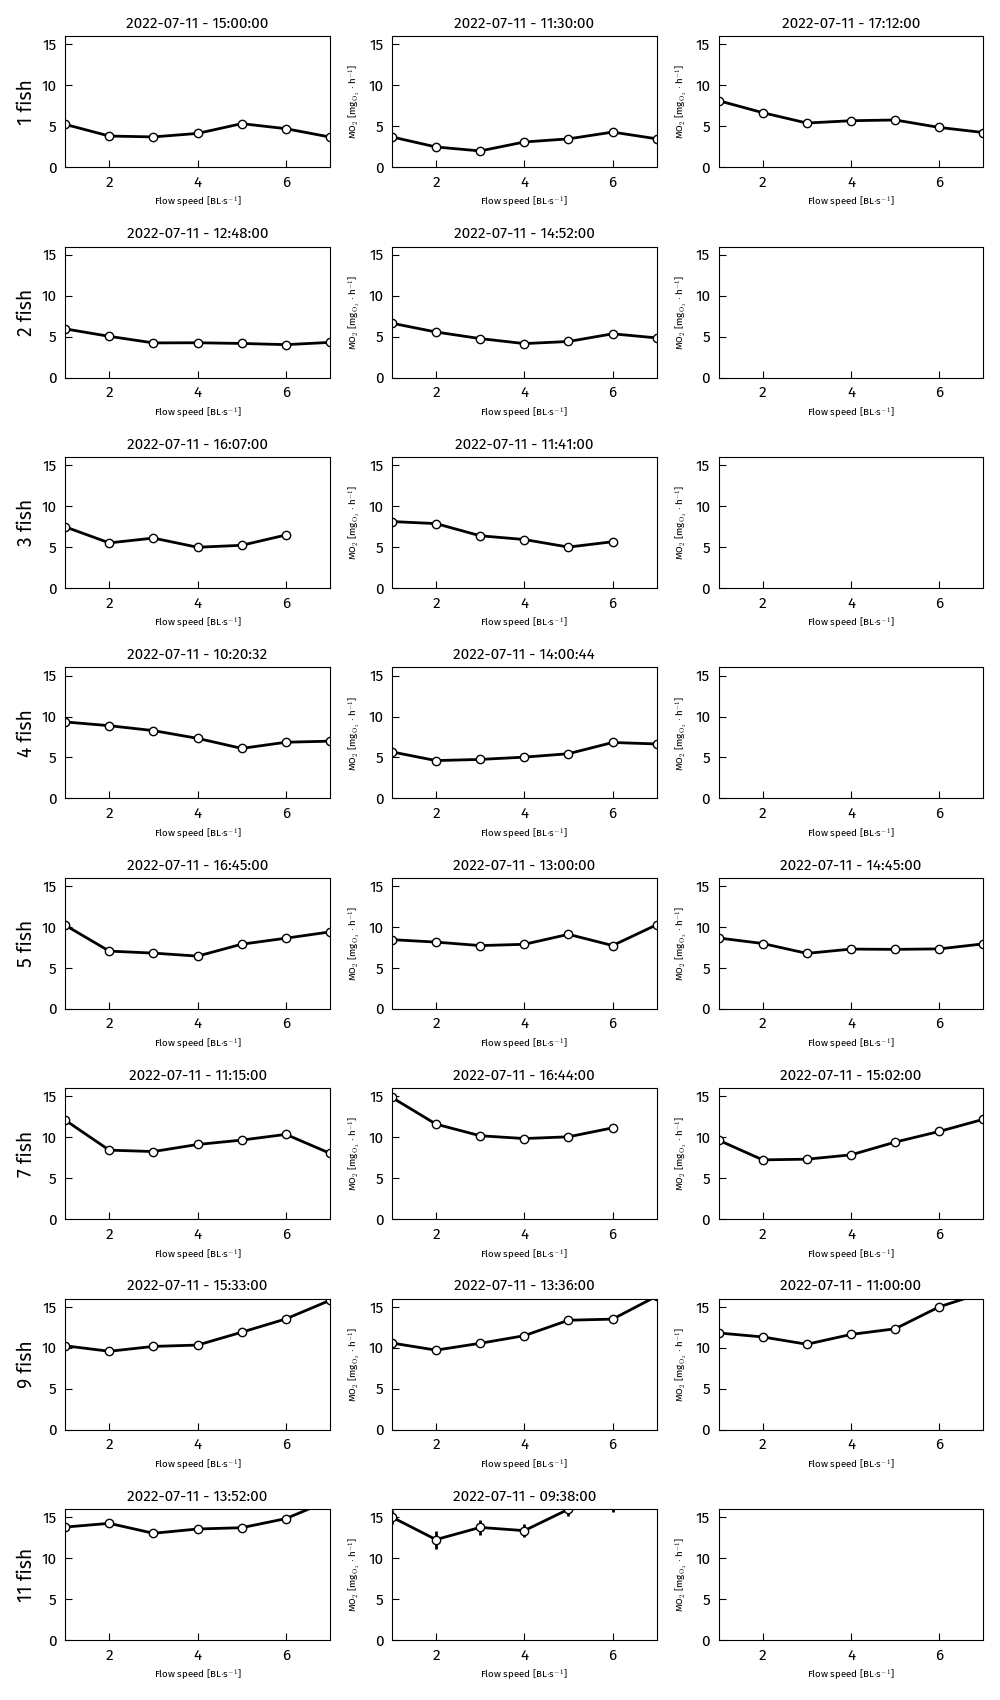

In [13]:

fig, ax = plt.subplots(len(np.unique(ds.number_of_fish)), 3, figsize=(10, 17))

for axe in ax.flatten():
    axe.set_xlim([1, 7])
    axe.set_ylim([0, 16])
    axe.set_ylabel(
        'MO$_2$ [mg$_{\mathrm{O}_2}$ $\cdot$ h${^{-1}}$]', fontsize=7)
    axe.set_xlabel('Flow speed [BL$\cdot$s$^{-1}$]', fontsize=7)


for i, n_fish in enumerate(np.sort(np.unique(ds.number_of_fish))): 
    
    data = ds.sel(number_of_fish=n_fish)

    n_exp = data.number_of_fish.size
    ax[i, 0].set_ylabel(f'{str(n_fish)} fish', fontsize=14)

    if n_exp==1: 
        data_temp = data

        ax[i, n_exp-1].errorbar(data_temp.speed, data_temp.metabolic_rate_segmented * data_temp.number_of_fish,
                                3 * data_temp.metabolic_rate_segmented_error * data_temp.number_of_fish, fmt='ko-', mfc='w')

    else: 
        for i_exp in range(n_exp): 
            data_temp = data.isel(number_of_fish=i_exp)

            ax[i, i_exp].errorbar(data_temp.speed, data_temp.metabolic_rate_segmented * data_temp.number_of_fish, 3 * data_temp.metabolic_rate_segmented_error * data_temp.number_of_fish, fmt='ko-', mfc='w')

            ax[i, i_exp].set_title(f'{data_temp.date} - {data_temp.t_exp.to_numpy()[0]}')


fig.tight_layout()


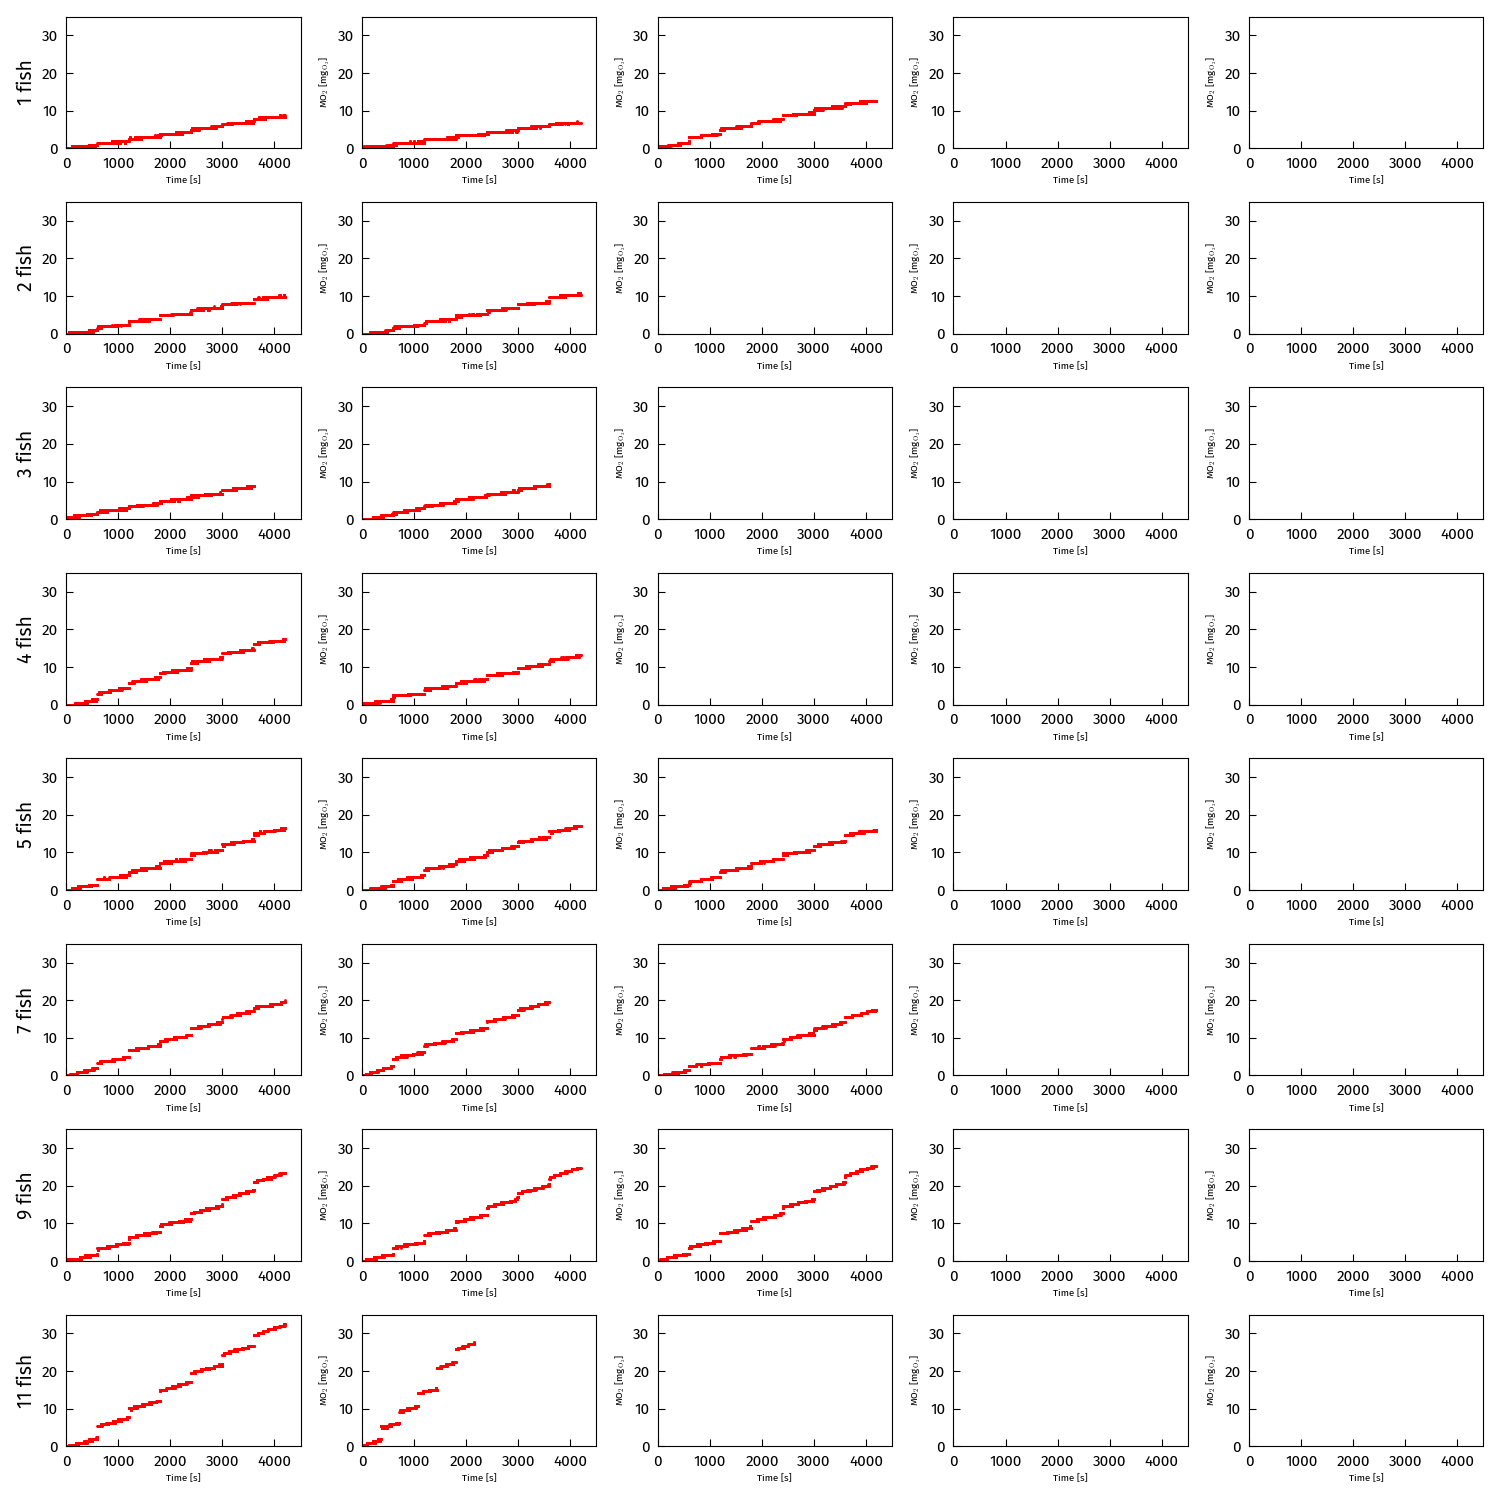

In [14]:

fig, ax = plt.subplots(len(np.unique(ds.number_of_fish)), 5, figsize=(15, 15))
for axe in ax.flatten():
    axe.set_ylim([0, 35])
    axe.set_xlim([0, 4500])
    axe.set_ylabel(
        'MO$_2$ [mg$_{\mathrm{O}_2}$]', fontsize=7)
    axe.set_xlabel('Time [s]', fontsize=7)

for i, n_fish in enumerate(np.sort(np.unique(ds.number_of_fish))):

    data = ds.sel(number_of_fish=n_fish)

    n_exp = data.number_of_fish.size

    ax[i, 0].set_ylabel(str(n_fish))
    ax[i, 0].set_ylabel(f'{str(n_fish)} fish', fontsize=14)

    if n_exp == 1:
        data_temp = data

        ax[i, n_exp-1].plot(data_temp.time, data_temp.oxy_consumed / n_fish, 'r.', ms=2)
    else:
        for i_exp in range(n_exp):
            data_temp = data.isel(number_of_fish=i_exp)

            ax[i, i_exp].plot(
                data_temp.time, data_temp.oxy_consumed, 'r.', ms=2)

fig.tight_layout()


In [15]:
ds_mean = ds.groupby('number_of_fish').mean()
ds_stdv = ds.groupby('number_of_fish').std()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.9472542525134493


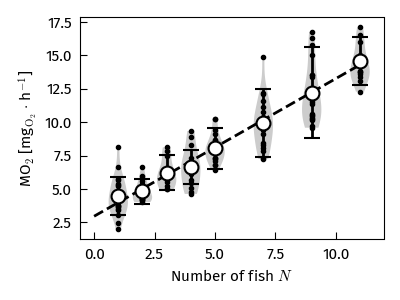

In [18]:


fig, ax = plt.subplots(figsize=(4,3)) 

data = ds_mean.mean(dim='speed')
std  = ds_mean.std(dim='speed')

dataset = ds.metabolic_rate_segmented * ds.number_of_fish

for n_fish in np.unique(dataset.number_of_fish): 

    curr_ds = dataset.sel(number_of_fish=n_fish)

    temp = curr_ds.to_numpy().flatten()
    parts = ax.violinplot(temp[~np.isnan(temp)], [
                          curr_ds.number_of_fish.to_numpy()[0]], showmeans=False, showmedians=False,
        showextrema=False, widths=0.8)
    for pc in parts['bodies']:
        pc.set_facecolor('k')
        pc.set_edgecolor('none')
        pc.set_alpha(0.2)

n = ds.speed.size

def norm(x):
    return np.sqrt(np.sum(x ** 2))
    
error  = (ds.std(dim='speed').metabolic_rate_segmented).groupby('number_of_fish').map(norm)

ax.errorbar(data.number_of_fish, data.metabolic_rate_segmented * data.number_of_fish, tinv5percent(n-1) / np.sqrt(n)
            * error * data.number_of_fish, fmt='ko', ms=10, mfc='w', mew=1.5, capsize=6)


ax.plot(ds.number_of_fish, ds.metabolic_rate_segmented * ds.number_of_fish, 'k.')
# ax.plot(data.number_of_fish, data.metabolic_rate_segmented * data.number_of_fish,
#         'ko', ms=10, mfc='w', mew=1.5, label='Avg. over all group sizes')

slope, intercept, r, p, se = linregress(data.number_of_fish, data.metabolic_rate_segmented * data.number_of_fish)

x = np.arange(ds.number_of_fish.max() + 1)
ax.plot(x, x * slope + intercept, 'k--', zorder=1)

# ax.axvline(0, ls='-', color='k', lw=0.75)

ax.set_xlabel('Number of fish $N$')
ax.set_ylabel(
    'MO$_2$ [mg$_{\mathrm{O}_2}$ $\cdot$ h${^{-1}}$]')

ax.legend(fontsize=8)

# fig.suptitle(f'Slope: {slope:.2f}' + ' mg$_{\mathrm{O}_2}$ $\cdot$ h${^{-1}}$ $\cdot$ fish$^{-1}$' + f' (r$^2$ = {r**2:.3f})' + '\n(Error bars: 95% confidence interval of the mean $\pm$' + f'{tinv5percent(n-1):.1f}' + '$\sigma$)');

print(intercept)
fig.tight_layout()

# Plot for MO_2 = f(N) - diff. speeds with diff. colors

>> Speed: 1 BL/s >>>>> Slope = 0.83 | Intercept = 4.86 | r$^2$ = 0.92
>> Speed: 2 BL/s >>>>> Slope = 0.81 | Intercept = 3.64 | r$^2$ = 0.97
>> Speed: 3 BL/s >>>>> Slope = 0.90 | Intercept = 2.83 | r$^2$ = 0.98
>> Speed: 4 BL/s >>>>> Slope = 0.95 | Intercept = 2.62 | r$^2$ = 0.99
>> Speed: 5 BL/s >>>>> Slope = 1.10 | Intercept = 2.36 | r$^2$ = 0.97
>> Speed: 6 BL/s >>>>> Slope = 1.20 | Intercept = 2.51 | r$^2$ = 0.98
>> Speed: 7 BL/s >>>>> Slope = 1.43 | Intercept = 1.76 | r$^2$ = 0.96


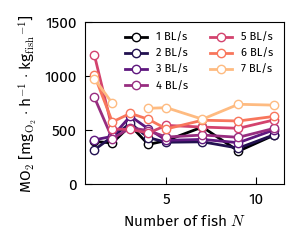

In [21]:


fig, ax = plt.subplots(figsize=(3, 2.45)) 

col = np.array(cmap.colors) / 255

intercepts = np.zeros(ds_mean.speed.size)
slopes     = np.zeros(ds_mean.speed.size)
std_errs = np.zeros(ds_mean.speed.size)
std_errs_intercepts = np.zeros(ds_mean.speed.size)

for i, speed in enumerate(ds_mean.speed): 
    ds_temp = ds_mean.sel(speed=speed)


    idx = np.where(~np.isnan(ds_temp.metabolic_rate_segmented))[0]
    res = linregress(ds_temp.number_of_fish.isel(number_of_fish=idx), \
                     (ds_temp.metabolic_rate_segmented * ds_temp.number_of_fish).isel(number_of_fish=idx))

    slope, intercept, r, p, se, sei = res.slope, res.intercept, res.rvalue, res.pvalue, res.stderr, res.intercept_stderr

    intercepts[i] = intercept
    slopes[i] = slope 
    std_errs[i] = se 
    std_errs_intercepts[i] = sei

    print(f'>> Speed: {int(speed)} BL/s >>>>> Slope = {slope:.2f} | Intercept = {intercept:.2f} | r$^2$ = {r**2:.2f}')

    #x[1].plot(ds_temp.number_of_fish, ds_temp.number_of_fish * slope, '-', color=col[i])

    d = (ds_temp.metabolic_rate_segmented * ds_temp.number_of_fish - intercept) / \
        ds_temp.number_of_fish / \
        ((ds_temp.mass_fish/1000)).mean(dim='fish')

    ax.plot(ds_temp.number_of_fish, d, '-o', mfc='w', color=col[i], label=f'{int(speed)} BL/s')
    

    # ax[1].axhline(np.mean(d), color=col[i], ls='--', lw=3)


ax.set_xlabel('Number of fish $N$')
ax.set_ylabel(
    'MO$_2$ [mg$_{\mathrm{O}_2}$ $\cdot$ h$^{-1}$ $\cdot$ kg$_{\mathrm{fish}}$$^{-1}$]')

ax.set_ylim(bottom=0, top=1500)
ax.legend(loc='upper right', ncol=2)
fig.tight_layout()


# Plot of MO_2 = f(N), avg. over all speeds (boxplots)

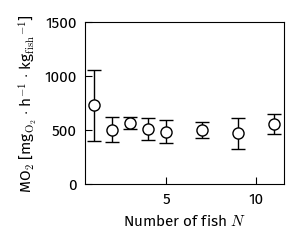

In [22]:
fig, ax = plt.subplots(figsize=(3,2.45))

d = (ds_mean.metabolic_rate_segmented * ds_mean.number_of_fish - intercepts) / \
    ds_mean.number_of_fish / \
    ((ds_mean.mass_fish/1000)).mean(dim='fish')

ax.errorbar(d.mean(dim='speed').number_of_fish, d.mean(dim='speed'),
            d.std(dim='speed'), fmt='ko', mfc='w', ms=8, capsize=5, lw=1) 

# ax.plot(d.number_of_fish, d, 'k.')
ax.set_xlabel('Number of fish $N$')
ax.set_ylabel('MO$_2$ [mg$_{\mathrm{O}_2}$ $\cdot$ h$^{-1}$ $\cdot$ kg$_{\mathrm{fish}}$$^{-1}$]')

# ax.set_title('Meta. r»te per unit of mass VS number of fish (avg. over all speeds)')
ax.set_ylim(bottom=0, top=1500)

fig.tight_layout()


>> Speed: 1 BL/s >>>>> Slope = 0.83 | Intercept = 4.86 | r$^2$ = 0.92
>> Speed: 2 BL/s >>>>> Slope = 0.81 | Intercept = 3.64 | r$^2$ = 0.97
>> Speed: 3 BL/s >>>>> Slope = 0.90 | Intercept = 2.83 | r$^2$ = 0.98
>> Speed: 4 BL/s >>>>> Slope = 0.95 | Intercept = 2.62 | r$^2$ = 0.99
>> Speed: 5 BL/s >>>>> Slope = 1.10 | Intercept = 2.36 | r$^2$ = 0.97
>> Speed: 6 BL/s >>>>> Slope = 1.20 | Intercept = 2.51 | r$^2$ = 0.98
>> Speed: 7 BL/s >>>>> Slope = 1.43 | Intercept = 1.76 | r$^2$ = 0.96


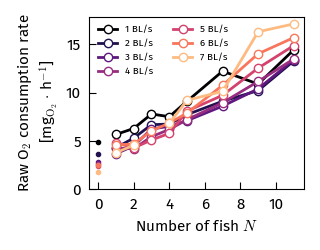

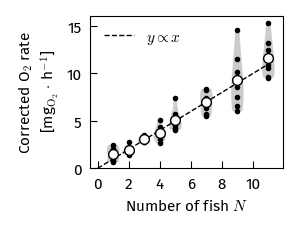

In [27]:
from re import U
from scipy.stats import linregress
from palettable.matplotlib import Magma_8 as cmap

fig, ax = plt.subplots(figsize=(3.2, 2.5)) 
fig2, ax2 = plt.subplots(figsize=(3, 2.3)) 
col = np.array(cmap.colors) / 255

intercepts = np.zeros(ds_mean.speed.size)
slopes     = np.zeros(ds_mean.speed.size)
std_errs = np.zeros(ds_mean.speed.size)
std_errs_intercepts = np.zeros(ds_mean.speed.size)

for i, speed in enumerate(ds_mean.speed): 
    ds_temp = ds_mean.sel(speed=speed)

    ax.plot(ds_temp.number_of_fish, \
        ds_temp.metabolic_rate_segmented * ds_temp.number_of_fish, \
            '-o', mfc='w', color=col[i], label=f'{int(speed)} BL/s')


    idx = np.where(~np.isnan(ds_temp.metabolic_rate_segmented))[0]
    res = linregress(ds_temp.number_of_fish.isel(number_of_fish=idx), \
                     (ds_temp.metabolic_rate_segmented * ds_temp.number_of_fish).isel(number_of_fish=idx))

    slope, intercept, r, p, se, sei = res.slope, res.intercept, res.rvalue, res.pvalue, res.stderr, res.intercept_stderr

    intercepts[i] = intercept
    slopes[i] = slope 
    std_errs[i] = se 
    std_errs_intercepts[i] = sei

    print(f'>> Speed: {int(speed)} BL/s >>>>> Slope = {slope:.2f} | Intercept = {intercept:.2f} | r$^2$ = {r**2:.2f}')

    #x[1].plot(ds_temp.number_of_fish, ds_temp.number_of_fish * slope, '-', color=col[i])

    d = (ds_temp.metabolic_rate_segmented * ds_temp.number_of_fish - intercept) / \
        ds_temp.number_of_fish / \
        ((ds_temp.mass_fish/1000)).mean(dim='fish')
    
    ax.plot(0, intercept, '.', color=col[i])

for i, N in enumerate(ds_mean.number_of_fish):
    d = ds_mean.sel(number_of_fish=N)
    data = (d.metabolic_rate_segmented * d.number_of_fish).to_numpy() - intercepts

    data = data[~np.isnan(data)]
    ax2.plot(int(N) * np.ones_like(data), data, 'k.')
    ax2.plot(int(N), data.mean(), 'ko', mfc='w', ms=7)
    # bp = ax2.boxplot(data, positions=[int(N)], widths=0.75, patch_artist=True)
    vp = ax2.violinplot(data, positions=[int(N)], showmeans=False, showmedians=False,
        showextrema=False, widths=0.8)
    for pc in vp['bodies']:
        pc.set_facecolor('k')
        pc.set_edgecolor('none')
        pc.set_alpha(0.2)
    # for patch in bp['boxes']:
    #     patch.set(facecolor='w') 
    # for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    #     plt.setp(bp[element], color='k') 

    

x = np.arange(12)
ax2.plot(x, x, 'k--', lw=1, zorder=0, label='$y\propto x$')
    # ax[1].axhline(np.mean(d), color=col[i], ls='--', lw=3)
ax.set_xlabel('Number of fish $N$')
ax.set_ylabel(
    'Raw O$_2$ consumption rate\n [mg$_{\mathrm{O}_2}$ $\cdot$ h$^{-1}$]')
ax.legend(fontsize=7, ncol=2)
ax.set_xlim(left=-0.5 )
ax.set_xticks(np.arange(12, step=2))
ax.set_ylim(bottom=0)
fig.tight_layout()

fig.savefig(f'{MANUPATH}/graphs/annexes/raw_mo2_without_correction_with_intercept.pdf')

ax2.set_xlabel('Number of fish $N$')
ax2.set_ylabel(
    'Corrected O$_2$ rate\n [mg$_{\mathrm{O}_2}$ $\cdot$ h$^{-1}$]')
ax2.legend(fontsize=11)
ax2.set_xlim(left=-0.5 )
ax2.set_xticks(np.arange(12, step=2))
ax2.set_ylim(bottom=0)
fig2.tight_layout()



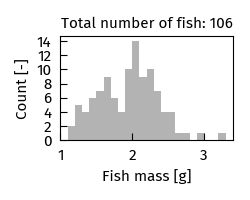

In [28]:
d = ds.mass_fish.to_numpy().flatten()
d = d[~np.isnan(d)]

fig, ax = plt.subplots(figsize=(2.5, 2))

ax.hist(d, np.arange(d.min(), d.max(), 0.1), color='0.7');
ax.set_ylabel('Count [-]')
ax.set_xlabel('Fish mass [g]')
ax.set_title(f'Total number of fish: {len(d)}')
ax.set_yticks(np.arange(0, 15, 2))

fig.tight_layout()

[4.85600772 3.64172272 2.83037994 2.61668717 2.36333076 2.51461014
 1.75964047]


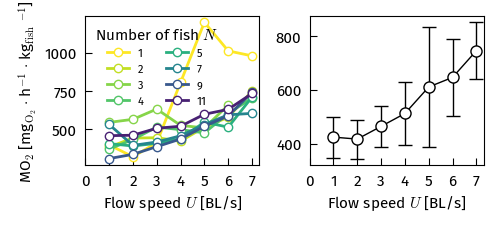

In [30]:
%matplotlib widget 

from palettable.cmocean.sequential import Thermal_12_r as cmap
fig, axs = plt.subplots(1, 2, figsize=(5, 2.3), sharey=False) 



###

ax = axs[0]
col = plt.cm.viridis_r(np.linspace(0, 1, 12))

lis = []
for n in np.unique(ds.number_of_fish): 

    ds_tmp = ds.sel(number_of_fish=n)
    all_pts = (ds_tmp.metabolic_rate_segmented  * n  - intercepts) / n / ((ds_tmp.mass_fish.mean(dim='fish')/1000)**0.9)
    #ax.plot(ds_tmp.speed, all_pts.T, 'k.')

    d = ds_tmp.mean(dim='number_of_fish')
    d_std = ds_tmp.std(dim='number_of_fish')

    m = int(ds_tmp.number_of_fish.mean())
    
    pts = (d.metabolic_rate_segmented * n - intercepts) / n / ((d.mass_fish.mean(dim='fish')/1000))
    pts_std = d_std.metabolic_rate_segmented / \
        ((d.mass_fish.mean(dim='fish')/1000))
    
    # ax.errorbar(d.speed, pts, pts_std, fmt='o-', label=f'{int(n)} fish', color=col[int(n)], ms=6, capsize=4, mfc ='w')
    ax.plot(d.speed, pts, 'o-', color=col[int(n)-1], ms=6, mfc ='w', label=f'{int(n)}')

    lis.append(pts.values)

lis = np.array(lis)
ax.legend(title='Number of fish $N$', ncol=2)
# ax.legend(fontsize=8)
ax.set_xlim(left=0)
# ax.set_ylim(bottom=0.)
ax.set_xlabel('Flow speed $U$ [BL/s]')
print(intercepts)
ax.set_xticks(np.arange(8))


ax = axs[1]
def power_0p9(x):
    return x**0.9

n = len(np.unique(ds_mean.number_of_fish))

mass = ((ds_mean.mass_fish/1000)).mean(dim=('fish', 'number_of_fish')).to_numpy()
# ax.errorbar(ds_mean.speed, slopes / mass, tinv5percent(n-1) / np.sqrt(n) *  std_errs / mass, fmt='ko', ms=8, mfc='w', capsize=5, lw=1) 

# ax.errorbar(ds_mean.speed, (ds_mean.metabolic_rate_segmented.mean('number_of_fish'), ds_mean.metabolic_rate_segmented.std('number_of_fish'), fmt='ko', ms=8, mfc='w', capsize=5, lw=1) 


ax.errorbar(ds_mean.speed, np.nanmean(lis, axis=0), np.nanstd(lis, axis=0), fmt='ko-', ms=8, mfc='w', capsize=5, lw=1) 
axs[0].set_ylabel('MO$_2$ [mg$_{\mathrm{O}_2}$ $\cdot$ h${^{-1}}$ $\cdot$ kg$_{\mathrm{fish}}$ $^{-1}$]')
ax.set_xlabel('Flow speed $U$ [BL/s]')

ax.set_xlim(left=0)
ax.set_xticks(np.arange(8))


fig.tight_layout()
